### Europe Network Analysis


Notebook for quick sanity checks and plots of the PyPSA-Earth test run.



### Sync the solved network (from repo root)

```bash

rsync -avz --progress \

  engs2523@arc-login.arc.ox.ac.uk:/data/engs-df-green-ammonia/engs2523/pypsa-earth/results/europe/networks/elec_s_37_ec_lcopt_Co2L-3h.nc \

  results/europe/networks/

```

In [1]:
# Download natura raster on first run
import cartopy; from cartopy import feature as cf
cf.NaturalEarthFeature("physical","land","10m")

In [2]:
from pathlib import Path

RESULT_PATH = Path('../results/europe-day-core-tech/networks/elec_s_140_ec_lcopt_Co2L-3h.nc')
if not RESULT_PATH.exists():
    raise FileNotFoundError(
        "Solved network missing. Run the rsync command at the top to copy elec_s_140_ec_lcopt_Co2L-3h.nc locally."
    )
print('Using network file:', RESULT_PATH.resolve())

Using network file: /Users/carlopalazzi/programming/pypsa_models/20251117-pypsa-earth-project/results/europe-day-core-tech/networks/elec_s_140_ec_lcopt_Co2L-3h.nc


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

try:
    import pypsa
except ImportError as exc:
    raise SystemExit('PyPSA missing. Install via mamba install -c conda-forge pypsa') from exc

try:
    import cartopy  # noqa: F401
    CARTOPY_AVAILABLE = True
except Exception:
    CARTOPY_AVAILABLE = False

print('PyPSA version:', pypsa.__version__)
print('Cartopy available:', CARTOPY_AVAILABLE)

PyPSA version: 0.28.0
Cartopy available: True


In [4]:
n = pypsa.Network(str(RESULT_PATH))
print(n)
print('Snapshots:', list(n.snapshots))
print('Buses:', len(n.buses), 'Lines:', len(n.lines), 'Generators:', len(n.generators))

INFO:pypsa.io:Imported network elec_s_140_ec_lcopt_Co2L-3h.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


PyPSA Network
Components:
 - Bus: 420
 - Carrier: 25
 - Generator: 990
 - GlobalConstraint: 1
 - Line: 134
 - Link: 669
 - Load: 113
 - StorageUnit: 82
 - Store: 280
Snapshots: 8
Snapshots: [Timestamp('2013-01-01 00:00:00'), Timestamp('2013-01-01 03:00:00'), Timestamp('2013-01-01 06:00:00'), Timestamp('2013-01-01 09:00:00'), Timestamp('2013-01-01 12:00:00'), Timestamp('2013-01-01 15:00:00'), Timestamp('2013-01-01 18:00:00'), Timestamp('2013-01-01 21:00:00')]
Buses: 420 Lines: 134 Generators: 990


## Installed capacities (MW)

In [5]:
cap_by_carrier = n.generators.groupby('carrier')['p_nom'].sum().sort_values(ascending=False)
cap_df = cap_by_carrier.to_frame(name='p_nom_MW')
cap_df

,p_nom_MW
carrier,
load shedding,612287.762714
CCGT,220837.550258
nuclear,129027.192613
coal,70837.033711
solar,68604.772977
lignite,56114.341913
onwind,53292.802624
ror,39950.530554
oil,13971.398495


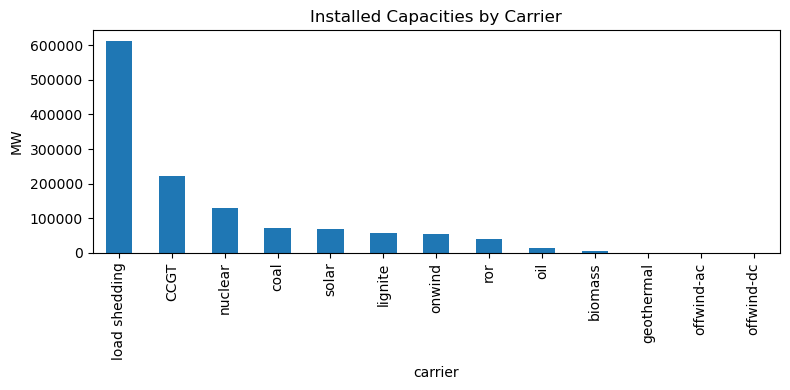

In [6]:
ax = cap_by_carrier.plot(kind='bar', figsize=(8, 4), title='Installed Capacities by Carrier')
ax.set_ylabel('MW')
plt.tight_layout()
plt.show()

## Generation mix (snapshot 0)

In [7]:
snap = n.snapshots[0]
tech_mix = n.generators_t.p.loc[snap].groupby(n.generators['carrier']).sum().sort_values(ascending=False)
tech_mix

carrier
nuclear          128468.296794
load shedding    112852.702501
onwind            69861.399630
ror               26511.444376
CCGT              25032.883769
biomass            4847.491482
offwind-dc           82.069389
geothermal           39.995337
coal                  0.070621
oil                   0.051491
lignite               0.026791
offwind-ac            0.000000
solar                 0.000000
Name: 2013-01-01 00:00:00, dtype: float64

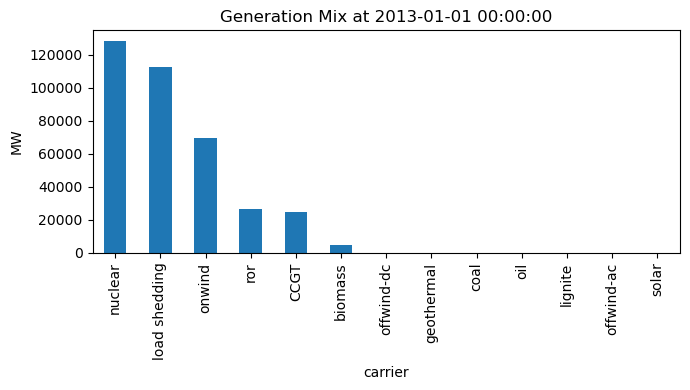

In [8]:
tech_mix.plot(kind='bar', figsize=(7, 4), title=f'Generation Mix at {snap}')
plt.ylabel('MW')
plt.tight_layout()
plt.show()

## Simple network map

/opt/homebrew/Caskroom/miniforge/base/envs/pypsa-earth-env/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


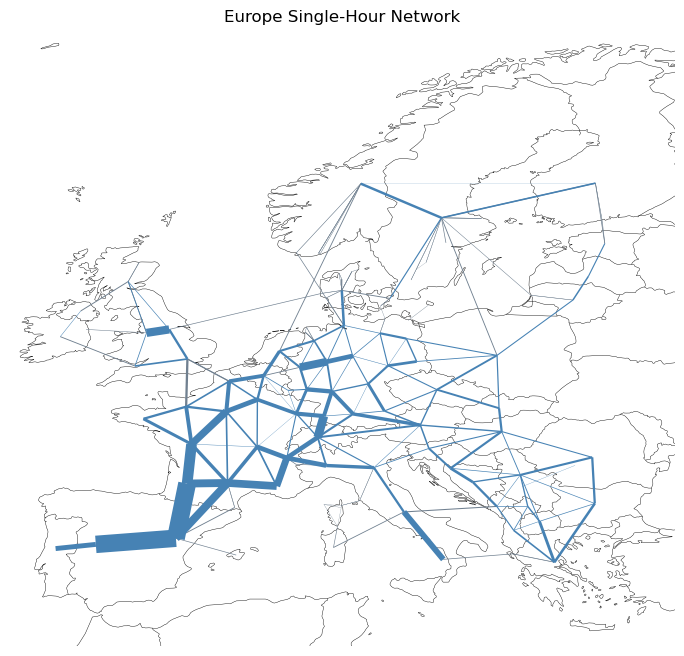

In [9]:
if CARTOPY_AVAILABLE:
    try:
        import cartopy.crs as ccrs
        plt.close("all")  # avoid reusing stale GeoAxes when re-running the cell
        fig, ax = plt.subplots(figsize=(9, 8), subplot_kw={"projection": ccrs.PlateCarree()})
        # scale factors tuned for visibility (increase if map still sparse)
        bus_sizes = (
            5e-5  # adjust this multiplier to grow/shrink bus bubbles
            * n.loads.groupby("bus").p_set.max().reindex(n.buses.index).fillna(0.0)
        )
        line_widths = 1e-4 * n.lines.s_nom_opt.fillna(n.lines.s_nom)  # increase for thicker AC lines
        link_widths = 1e-4 * n.links.p_nom_opt.fillna(n.links.p_nom)  # increase for thicker DC links

        n.plot(
            ax=ax,
            boundaries=(-11, 30, 34, 72),
            title="Europe Single-Hour Network",
            bus_sizes=bus_sizes,
            bus_colors="tab:orange",
            line_widths=line_widths,
            line_colors="steelblue",
            link_widths=link_widths,
            link_colors="slategray",
            branch_components={"Line", "Link"},
        )
        plt.show()
    except Exception as exc:
        print("Map plotting failed:", exc)
else:
    print("Cartopy not available; skipping geographic map.")

## Bus-level generation pies (snapshot 0)

/opt/homebrew/Caskroom/miniforge/base/envs/pypsa-earth-env/lib/python3.10/site-packages/cartopy/mpl/feature_artist.py:144: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


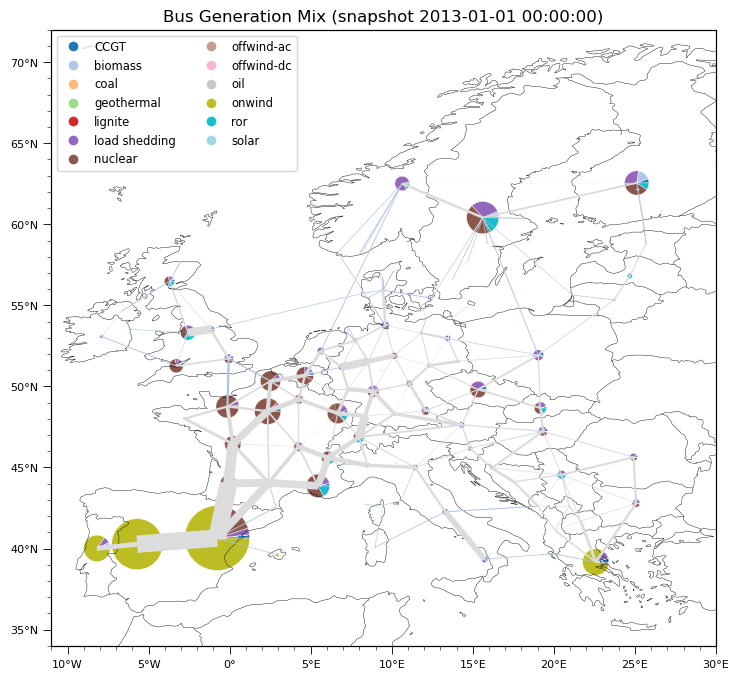

In [10]:
import numpy as np
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter

if CARTOPY_AVAILABLE and not n.generators_t.p.empty:
    gen_flow = n.generators_t.p.loc[snap]
    if gen_flow.abs().sum() == 0:
        print("Generator dispatch is zero at this snapshot; check that you're loading the solved network.")
    else:
        meta = n.generators[["bus", "carrier"]]
        df = pd.DataFrame({"p": gen_flow, "bus": meta.bus, "carrier": meta.carrier})
        pies = df.pivot_table(index="bus", columns="carrier", values="p", aggfunc="sum").fillna(0.0)
        pies = pies[pies.sum(axis=1) > 0]
        if len(pies) == 0:
            print("No generation at snapshot to plot pies.")
        else:
            from matplotlib.patches import Wedge

            fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})
            # tweak multipliers below to scale AC line and DC link thickness in the background map
            line_widths = 1e-4 * n.lines.s_nom_opt.fillna(n.lines.s_nom)
            link_widths = 1e-4 * n.links.p_nom_opt.fillna(n.links.p_nom)
            try:
                n.plot(
                    ax=ax,
                    boundaries=(-11, 30, 34, 72),
                    bus_sizes=0.0,
                    line_widths=line_widths,
                    line_colors="gainsboro",
                    link_widths=link_widths,
                    link_colors="lightsteelblue",
                    branch_components={"Line", "Link"},
                )
            except Exception as exc:
                print("n.plot failed; falling back to plain coastlines:", exc)
                ax.set_extent((-11, 30, 34, 72))
                ax.coastlines()
            carriers = pies.columns.tolist()
            colors = plt.cm.tab20(np.linspace(0, 1, len(carriers)))
            color_map = dict(zip(carriers, colors))
            max_total = pies.sum(axis=1).max()
            r_scale = 2.0 / max_total if max_total > 0 else 0.0  # adjust numerator for larger/smaller pies
            for bus, row in pies.iterrows():
                x = n.buses.loc[bus, "x"]
                y = n.buses.loc[bus, "y"]
                total = row.sum()
                if total <= 0:
                    continue
                start = 0.0
                radius = total * r_scale
                for carrier in carriers:
                    val = row.get(carrier, 0.0)
                    if val <= 0:
                        continue
                    angle = 360 * val / total
                    wedge = Wedge((x, y), radius, start, start + angle, facecolor=color_map[carrier], edgecolor="white", linewidth=0.3)
                    ax.add_patch(wedge)
                    start += angle
            legend_handles = [
                plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color_map[c], label=c, markersize=8)
                for c in carriers
            ]
            ax.legend(handles=legend_handles, loc="upper left", fontsize="small", ncol=2, frameon=True)

            ax.set_axis_on()
            for spine in ax.spines.values():
                spine.set_visible(True)
            ax.set_xlim(-11, 30)
            ax.set_ylim(34, 72)

            major_xticks = np.arange(-10, 31, 5)
            major_yticks = np.arange(35, 73, 5)
            ax.set_xticks(major_xticks, crs=ccrs.PlateCarree())
            ax.set_yticks(major_yticks, crs=ccrs.PlateCarree())
            ax.xaxis.set_major_formatter(LongitudeFormatter())
            ax.yaxis.set_major_formatter(LatitudeFormatter())
            ax.tick_params(axis="both", which="major", labelsize=8, length=6, width=0.6, direction="out")
            ax.xaxis.set_minor_locator(mticker.MultipleLocator(1))
            ax.yaxis.set_minor_locator(mticker.MultipleLocator(1))
            ax.tick_params(axis="both", which="minor", length=3, width=0.4, direction="out")

            ax.set_title(f"Bus Generation Mix (snapshot {snap})")
            plt.show()
elif not CARTOPY_AVAILABLE:
    print("Cartopy not available; skipping pie map.")
else:
    print("No generator dispatch stored in this network file. Sync the solved network (elec_s_140...).")

## Line loading distribution

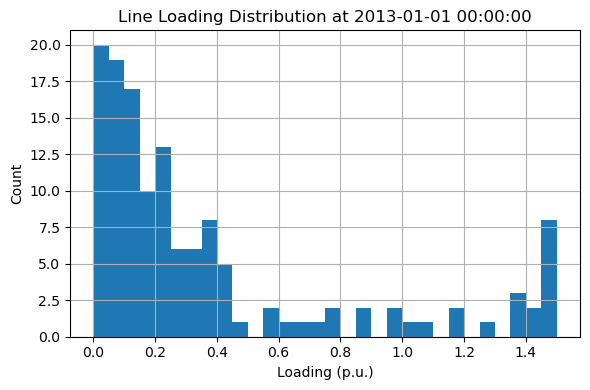

In [11]:
if 'p0' in n.lines_t:
    loading = (n.lines_t.p0.loc[snap].abs() / n.lines.s_nom).fillna(0.0)
    plt.figure(figsize=(6, 4))
    loading.clip(upper=1.5).hist(bins=30)
    plt.title(f'Line Loading Distribution at {snap}')
    plt.xlabel('Loading (p.u.)')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()
else:
    print('Line flow results missing in network file.')

## Marginal prices

In [12]:
if 'marginal_price' in n.buses_t:
    prices = n.buses_t.marginal_price.loc[snap].dropna().sort_values(ascending=False)
    price_table = pd.DataFrame({
        'bus': prices.index,
        'price_EUR_per_MWh': prices.values
    })
    price_table.head(10)
else:
    print('No marginal prices stored in buses_t.')

## Objective value and cost breakdown

In [13]:
if hasattr(n, 'objective'):
    total_obj = float(n.objective / 1e6)
    print(f'Total objective: {total_obj:.2f} million EUR')
else:
    print('Objective attribute missing; using cost components only.')

gen_nom = n.generators.get('p_nom_opt', n.generators['p_nom'])
capex_gen = (gen_nom * n.generators.get('capital_cost', 0.0)).sum()

if len(n.stores):
    store_nom = n.stores.get('e_nom_opt', n.stores['e_nom'])
    capex_store = (store_nom * n.stores.get('capital_cost', 0.0)).sum()
else:
    capex_store = 0.0

if 'capital_cost' in n.lines.columns:
    line_nom = n.lines.get('s_nom_opt', n.lines['s_nom'])
    capex_lines = (line_nom * n.lines['capital_cost']).sum()
else:
    capex_lines = 0.0

operating_costs = (n.objective - (capex_gen + capex_store + capex_lines)) if hasattr(n, 'objective') else float('nan')

pd.Series({
    'generator_capex_EUR': capex_gen,
    'storage_capex_EUR': capex_store,
    'line_capex_EUR': capex_lines,
    'operating_costs_EUR': operating_costs
}) / 1e6

Total objective: 712090925.47 million EUR


generator_capex_EUR    2.525920e+05
storage_capex_EUR      9.344669e+03
line_capex_EUR         3.175176e+04
operating_costs_EUR    7.117972e+08
dtype: float64

In [14]:
co2_constraints = n.global_constraints[n.global_constraints.index.str.contains('co2', case=False)]
if co2_constraints.empty:
    display(n.global_constraints)
    print("No CO2-labeled global constraint found; above shows all available constraints.")
else:
    display(co2_constraints[[c for c in co2_constraints.columns if c not in {'carrier_attribute'}]])
    if 'sense' in co2_constraints.columns and 'constant' in co2_constraints.columns:
        for name, row in co2_constraints.iterrows():
            print(f"Constraint {name}: {row['sense']} {row['constant']:.2f} tCO2")

carrier_emissions = n.carriers.get('co2_emissions')
if carrier_emissions is None or carrier_emissions.isnull().all():
    print("Carrier sheet lacks co2_emissions values; cannot compute realised emissions.")
else:
    def component_emissions(power_df, component_df):
        if power_df is None or power_df.empty:
            return 0.0
        factors = component_df['carrier'].map(carrier_emissions).fillna(0.0)
        return power_df.mul(factors, axis=1).sum().sum()

    gen_emissions = component_emissions(n.generators_t.p, n.generators)
    link_emissions = component_emissions(getattr(n.links_t, 'p0', None), n.links)
    store_emissions = component_emissions(getattr(n.stores_t, 'p', None), n.stores)
    total_operational_co2 = gen_emissions + link_emissions + store_emissions
    print(f"Realised operational CO2: {total_operational_co2:.2f} tCO2")


,sense,constant,mu,type,investment_period
GlobalConstraint,,,,,
CO2Limit,<=,77500000.0,-1.464519e+06,primary_energy,NaN


Constraint CO2Limit: <= 77500000.00 tCO2
Realised operational CO2: 41066.10 tCO2


## Notes
- Extend to longer horizons or additional carriers via `config/default-single-timestep.yaml`.
- Add further aggregation cells (country mix, storage flows, etc.) as needed.

In [15]:
import pypsa
n_diag = pypsa.Network(RESULT_PATH)
assert n_diag.buses[['x','y']].notna().all().all()

INFO:pypsa.io:Imported network elec_s_140_ec_lcopt_Co2L-3h.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [16]:
line_widths_raw = n_diag.lines.s_nom_opt.fillna(n_diag.lines.s_nom)
print("Lines with zero rating:", (line_widths_raw <= 0).sum(), " / ", len(line_widths_raw))
print("Bus coords missing:", n_diag.buses[['x','y']].isna().any(axis=1).sum())
if hasattr(n_diag, 'loads_t') and 'p_set' in n_diag.loads_t:
    peak_loads = n_diag.loads_t.p_set.max()  # per-load max over snapshots
    load_per_bus = peak_loads.groupby(n_diag.loads.loc[peak_loads.index, 'bus']).sum()
    print("Peak load per bus summary (MW):")
    print(load_per_bus.describe())
else:
    print("Load time series missing; confirm you're opening the solved network export.")

Lines with zero rating: 0  /  134
Bus coords missing: 0
Peak load per bus summary (MW):
count      112.000000
mean      4555.712520
std       5405.772223
min          0.780526
25%        300.418376
50%       2514.117263
75%       6636.823186
max      22689.994759
dtype: float64
